In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load base quantized model
base_model_name = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"
peft_model_id = "Deanna/doctorgpt-ft"

# Load base model & tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)

# Load PEFT adapter on top of base model
model = PeftModel.from_pretrained(base_model, peft_model_id)
model.eval()


Some weights of the model checkpoint at TheBloke/Mistral-7B-Instruct-v0.2-GPTQ were not used when initializing MistralForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.self_attn.v_proj.bias', 'model.layers.11.mlp.down_proj.bias', 'model.layers.11

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (k_proj): QuantLinear()
              (o_proj): QuantLinear()
              (q_proj): lora.QuantLinear(
                (base_layer): QuantLinear()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): Modul

#Evaluation for a single query

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt_tab')

# Fix pad_token issue
tokenizer.pad_token = tokenizer.eos_token

# Input prompt and reference
inputs = ["I have diabetes. How do I manage my weight?"]
references = [
    "In managing weight with diabetes, focus on a balanced diet, regular physical activity, and blood sugar monitoring. Eat whole foods like vegetables, lean proteins, and whole grains, and avoid sugary beverages and processed foods. Regular exercise and consultation with a healthcare provider are essential. Monitor blood sugar levels consistently to make informed adjustments."
]

predictions = []

for prompt in inputs:
    # Tokenize with attention_mask and move to model's device
    inputs_encoded = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    input_ids = inputs_encoded["input_ids"].to(model.device)
    attention_mask = inputs_encoded["attention_mask"].to(model.device)

    # Generate response
    output_ids = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=150,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode output
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    predictions.append(output_text)

# Print predictions
for i, pred in enumerate(predictions):
    print(f"\nPrompt: {inputs[i]}")
    print(f"Prediction: {pred}")
    print(f"Reference: {references[i]}")

# === Evaluation ===
smoothie = SmoothingFunction().method4
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

bleu_scores = []
rouge_scores = []

for pred, ref in zip(predictions, references):
    bleu = sentence_bleu(
        [nltk.word_tokenize(ref.lower())],
        nltk.word_tokenize(pred.lower()),
        smoothing_function=smoothie
    )
    bleu_scores.append(bleu)

    rouge = scorer.score(ref, pred)
    rouge_scores.append(rouge)

# Show evaluation results
print(f"\nAverage BLEU: {sum(bleu_scores) / len(bleu_scores):.4f}")
print(f"Average ROUGE-1: {sum(r['rouge1'].fmeasure for r in rouge_scores)/len(rouge_scores):.4f}")
print(f"Average ROUGE-2: {sum(r['rouge2'].fmeasure for r in rouge_scores)/len(rouge_scores):.4f}")
print(f"Average ROUGE-L: {sum(r['rougeL'].fmeasure for r in rouge_scores)/len(rouge_scores):.4f}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Prompt: I have diabetes. How do I manage my weight?
Prediction: I have diabetes. How do I manage my weight?

Weight management is an important part of managing diabetes. Here are some tips to help you manage your weight:

1. Eat a healthy and balanced diet: Aim for a variety of fruits, vegetables, lean proteins, and whole grains. Avoid sugary and processed foods.
2. Portion control: Be mindful of portion sizes. Use smaller plates and bowls to help control portion sizes.
3. Regular physical activity: Aim for at least 150 minutes of moderate-intensity aerobic activity or 75 minutes of vigorous-intensity aerobic activity per week.
4. Stay hydrated: Drink plenty of water throughout the day. Avoid sug
Reference: In managing weight with diabetes, focus on a balanced diet, regular physical activity, and blood sugar monitoring. Eat whole foods like vegetables, lean proteins, and whole grains, and avoid sugary beverages and processed foods. Regular exercise and consultation with a healthcare p

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2a72dcd963c0c12a8b9440a73968bd6f6fe9fb2242f25a42725f9408f9028344
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


#Evalutation with multiple queries

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt_tab')

# Fix pad_token issue
tokenizer.pad_token = tokenizer.eos_token

# Input prompt and reference
inputs = [
    "I have diabetes. How do I manage my weight?",
    "Can I eat fruits if I have type 2 diabetes?",
    "How often should I check my blood sugar levels?",
    "What are some signs of low blood sugar?",
    "Is it safe to exercise with diabetes?",
    "What should I do if I miss a dose of insulin?",
    "Are artificial sweeteners safe for people with diabetes?",
    "How does fiber affect blood sugar levels?",
    "Can stress raise my blood sugar?",
    "What's the difference between type 1 and type 2 diabetes?"
]

references = [
    "To manage weight with diabetes, eat a balanced diet with whole grains, lean protein, and vegetables. Avoid sugary drinks and processed foods. Exercise regularly and monitor your blood sugar. Consult a healthcare provider for a personalized plan.",

    "Yes, you can eat fruits with type 2 diabetes. Choose fresh fruits with low glycemic index like berries, apples, and oranges. Watch portion sizes and avoid fruit juices or dried fruits with added sugar.",

    "Blood sugar should generally be checked 1–4 times daily depending on your treatment plan. People on insulin may need more frequent checks. Follow your doctor’s advice.",

    "Signs of low blood sugar include shakiness, sweating, confusion, irritability, dizziness, and rapid heartbeat. Severe cases can lead to fainting or seizures.",

    "Yes, exercise is safe and beneficial with diabetes. It helps control blood sugar and weight. Monitor blood sugar before and after workouts, and carry fast-acting carbs in case of lows.",

    "If you miss a dose of insulin, check your blood sugar and follow your doctor's instructions. Do not double the next dose without medical advice.",

    "Most artificial sweeteners like aspartame and stevia are considered safe for people with diabetes when used in moderation. They do not raise blood sugar levels.",

    "Fiber slows digestion and helps prevent blood sugar spikes. Include soluble fiber from oats, beans, and vegetables in your diet to support glucose control.",

    "Yes, stress can raise blood sugar by triggering hormone changes that affect insulin. Managing stress through exercise, sleep, and relaxation techniques is important for diabetes control.",

    "Type 1 diabetes is an autoimmune condition where the body doesn't produce insulin. Type 2 is more common and involves insulin resistance. Both require lifestyle management and sometimes medication."
]

predictions = []

for prompt in inputs:
    # Tokenize with attention_mask and move to model's device
    inputs_encoded = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    input_ids = inputs_encoded["input_ids"].to(model.device)
    attention_mask = inputs_encoded["attention_mask"].to(model.device)

    # Generate response
    output_ids = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=150,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode output
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    predictions.append(output_text)

# Print predictions
for i, pred in enumerate(predictions):
    print(f"\nPrompt: {inputs[i]}")
    print(f"Prediction: {pred}")
    print(f"Reference: {references[i]}")

# === Evaluation ===
smoothie = SmoothingFunction().method4
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

bleu_scores = []
rouge_scores = []

for pred, ref in zip(predictions, references):
    bleu = sentence_bleu(
        [nltk.word_tokenize(ref.lower())],
        nltk.word_tokenize(pred.lower()),
        smoothing_function=smoothie
    )
    bleu_scores.append(bleu)

    rouge = scorer.score(ref, pred)
    rouge_scores.append(rouge)

# Show evaluation results
print(f"\nAverage BLEU: {sum(bleu_scores) / len(bleu_scores):.4f}")
print(f"Average ROUGE-1: {sum(r['rouge1'].fmeasure for r in rouge_scores)/len(rouge_scores):.4f}")
print(f"Average ROUGE-2: {sum(r['rouge2'].fmeasure for r in rouge_scores)/len(rouge_scores):.4f}")
print(f"Average ROUGE-L: {sum(r['rougeL'].fmeasure for r in rouge_scores)/len(rouge_scores):.4f}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Prompt: I have diabetes. How do I manage my weight?
Prediction: I have diabetes. How do I manage my weight?

Weight management is an important part of managing diabetes. Here are some tips to help you manage your weight:

1. Eat a healthy and balanced diet: Aim for a variety of fruits, vegetables, lean proteins, and whole grains. Avoid sugary and processed foods.
2. Portion control: Be mindful of portion sizes. Use smaller plates and bowls to help control portion sizes.
3. Regular physical activity: Aim for at least 150 minutes of moderate-intensity aerobic activity or 75 minutes of vigorous-intensity aerobic activity per week.
4. Stay hydrated: Drink plenty of water throughout the day. Avoid sug
Reference: To manage weight with diabetes, eat a balanced diet with whole grains, lean protein, and vegetables. Avoid sugary drinks and processed foods. Exercise regularly and monitor your blood sugar. Consult a healthcare provider for a personalized plan.

Prompt: Can I eat fruits if I have 

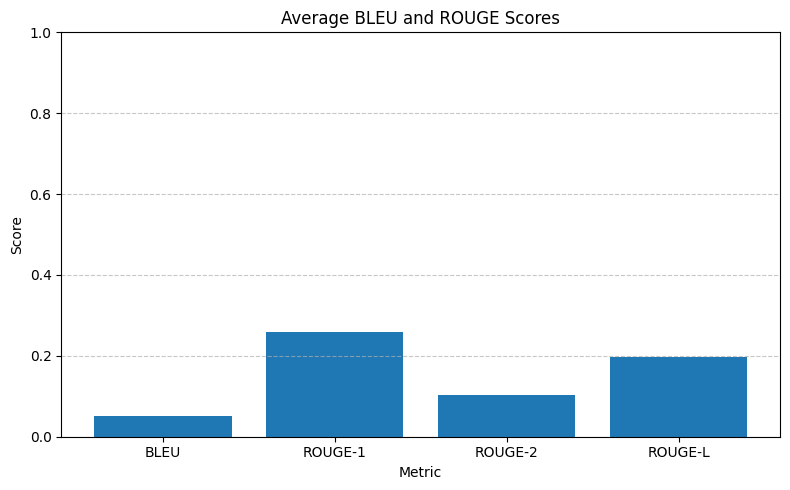

In [ ]:
import matplotlib.pyplot as plt

# Compute average scores
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_rouge1 = sum(r['rouge1'].fmeasure for r in rouge_scores) / len(rouge_scores)
avg_rouge2 = sum(r['rouge2'].fmeasure for r in rouge_scores) / len(rouge_scores)
avg_rougeL = sum(r['rougeL'].fmeasure for r in rouge_scores) / len(rouge_scores)

# Data for plotting
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [avg_bleu, avg_rouge1, avg_rouge2, avg_rougeL]

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, scores)
plt.ylim(0, 1)
plt.title("Average BLEU and ROUGE Scores")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
df = pd.read_json('/content/HealthCareMagic-100k (2).json')

In [ ]:
import pandas as pd

In [ ]:
dt = df.iloc[0].T

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
dt

,0
instruction,"If you are a doctor, please answer the medical questions based on the patient's description."
input,"I woke up this morning feeling the whole room is spinning when i was sitting down. I went to the bathroom walking unsteadily, as i tried to focus i feel nauseous. I try to vomit but it wont come out.. After taking panadol and sleep for few hours, i still feel the same.. By the way, if i lay down or sit down, my head do not spin, only when i want to move around then i feel the whole world is spinning.. And it is normal stomach discomfort at the same time? Earlier after i relieved myself, the spinning lessen so i am not sure whether its connected or coincidences.. Thank you doc!"
output,"Hi, Thank you for posting your query. The most likely cause for your symptoms is benign paroxysmal positional vertigo (BPPV), a type of peripheral vertigo. In this condition, the most common symptom is dizziness or giddiness, which is made worse with movements. Accompanying nausea and vomiting are common. The condition is due to problem in the ear, and improves in a few days on own. Betahistine tablets would help relieve your symptoms. Doing vestibular rehabilitation or adaptation exercises would prevent the recurrence of these symptoms. An ENT evaluation would also help. I hope it helps. Best wishes, Chat Doctor."


In [ ]:
df

,instruction,input,output
0,"If you are a doctor, please answer the medical questions based on the patient's description.","I woke up this morning feeling the whole room is spinning when i was sitting down. I went to the bathroom walking unsteadily, as i tried to focus i feel nauseous. I try to vomit but it wont come out.. After taking panadol and sleep for few hours, i still feel the same.. By the way, if i lay down or sit down, my head do not spin, only when i want to move around then i feel the whole world is spinning.. And it is normal stomach discomfort at the same time? Earlier after i relieved myself, the spinning lessen so i am not sure whether its connected or coincidences.. Thank you doc!","Hi, Thank you for posting your query. The most likely cause for your symptoms is benign paroxysmal positional vertigo (BPPV), a type of peripheral vertigo. In this condition, the most common symptom is dizziness or giddiness, which is made worse with movements. Accompanying nausea and vomiting are common. The condition is due to problem in the ear, and improves in a few days on own. Betahistine tablets would help relieve your symptoms. Doing vestibular rehabilitation or adaptation exercises would prevent the recurrence of these symptoms. An ENT evaluation would also help. I hope it helps. Best wishes, Chat Doctor."
1,"If you are a doctor, please answer the medical questions based on the patient's description.",My baby has been pooing 5-6 times a day for a week. In the last few days it has increased to 7 and they are very watery with green stringy bits in them. He does not seem unwell i.e no temperature and still eating. He now has a very bad nappy rash from the pooing ...help!,Hi... Thank you for consulting in Chat Doctor. It seems your kid is having viral diarrhea. Once it starts it will take 5-7 days to completely get better. Unless the kids having low urine output or very dull or excessively sleepy or blood in motion or green bilious vomiting...you need not worry. There is no need to use antibiotics unless there is blood in the motion. Antibiotics might worsen if unnecessarily used causing antibiotic associated diarrhea. I suggest you use zinc supplements (Z&D Chat Doctor.
2,"If you are a doctor, please answer the medical questions based on the patient's description.","Hello, My husband is taking Oxycodone due to a broken leg/surgery. He has been taking this pain medication for one month. We are trying to conceive our second baby. Will this medication afect the fetus? Or the health of the baby? Or can it bring birth defects? Thank you.","Hello, and I hope I can help you today.First, there is no medication that can be taken by the father that has any way to get into your system or a baby if you conceive. Medications can only affect a fetus if you take it while pregnant. The only issue is that certain medications may decrease a men sperm count and affect fertility, however pain medications like Oxycodone do not have this effect. So there is no reason for you to worry about conceiving while taking this medication. The best way you can prepare for a healthy pregnancy is to follow a well-balanced diet, limit alcohol consumption and avoid cigarette smoke, and take a daily prenatal vitamin or folic acid, as folic acid supplements in early pregnancy helps to prevent certain types of birth defects. I hope this answers your question and best wishes for your upcoming pregnancy,"
3,"If you are a doctor, please answer the medical questions based on the patient's description.","lump under left nipple and stomach pain (male) Hi,I have recently noticed a few weeks ago a lump under my nipple, it hurts to touch and is about the size of a quarter. Also I have bern experiencing stomach pains that prevent me from eating. I immediatly feel full and have extreme pain. Please help","HI. You have two different problems. The lump under the nipple should be removed, biopsied. This will help you to get rid of the disease, and you get a diagnosis. Second p